# Facial Identification System (Binary Classifier)
## Packages imported

In [408]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from random import randrange

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

import os
from numpy import genfromtxt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv3D, Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.image import rgb_to_grayscale
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

## Setting up the training/dev datasets

In [420]:
BATCH_SIZE = 128
IMG_SIZE = (64, 64)
directory = "dataset/"
seed = randrange(100)
print('seed:', seed)
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=seed)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=seed)


seed: 11
Found 2228 files belonging to 2 classes.
Using 1783 files for training.
Found 2228 files belonging to 2 classes.
Using 445 files for validation.


## Plot some images from the training set

['Brad New', 'Lynn New']


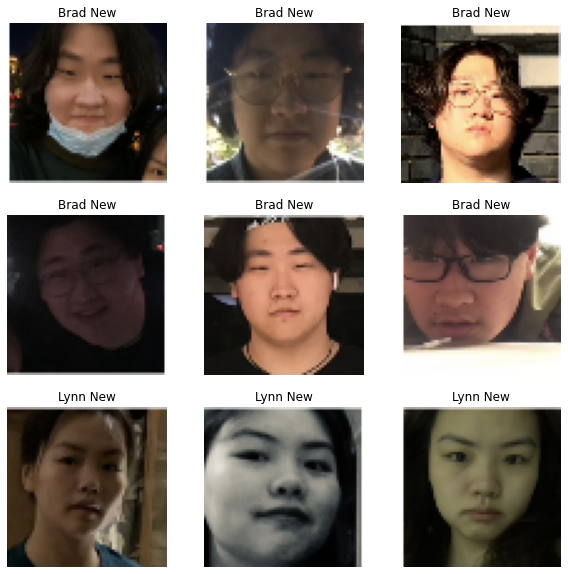

In [421]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [422]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Defined data augmenter

In [423]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(Rescaling(1/255))
    ### END CODE HERE
    
    return data_augmentation

## Experimental model 1

In [158]:
def model1(img_size = IMG_SIZE, data_augmentation = data_augmenter()):
    
    input_shape = img_size + (3,)
    
    # Input with appropriate input shape
    X_input = Input(shape = input_shape)

    # Apply data augmentation to the inputs
    X = data_augmentation(X_input)

    # First Block
    X = Conv2D(8, 3, strides = 1, name = 'CONV1',
                    kernel_regularizer=tf.keras.regularizers.L2(0.005),
                    activity_regularizer=tf.keras.regularizers.L2(0.005))(X_input)
    X = BatchNormalization(axis = 1, epsilon=0.001, name = 'BN1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    
    # Second Block
    X = Conv2D(8, 3, strides = 1, name = 'CONV3',
                    kernel_regularizer=tf.keras.regularizers.L2(0.005),
                    activity_regularizer=tf.keras.regularizers.L2(0.005))(X)
    X = BatchNormalization(axis = 1, epsilon=0.0001, name = 'BN3')(X)
    X = Activation('relu')(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=2)(X)
    X = Flatten()(X)
    X = Dense(8, name='dense_layer')(X)
    X = Dense(8, name='dense_layer2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.001, name = 'BN4')(X)

    X = Dense(1, activation = 'sigmoid')(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='Model1')
    
    return model


### Training the model

In [216]:
model_1 = model1()
model_1.summary()
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history1 = model_1.fit(train_dataset, validation_data=validation_dataset, epochs=100)

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
CONV1 (Conv2D)               (None, 62, 62, 8)         224       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 62, 62, 8)         248       
_________________________________________________________________
activation_85 (Activation)   (None, 62, 62, 8)         0         
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 28, 28, 8)         584       
_________________________________________________________________
BN3 (BatchNormalization)     (None, 28, 28, 8)         112  

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


14/14 [==============================] - 4s 215ms/step - loss: 276040.2188 - accuracy: 0.6590 - val_loss: 79740.2266 - val_accuracy: 0.6270
Epoch 2/100
14/14 [==============================] - 3s 218ms/step - loss: 64108.6875 - accuracy: 0.6366 - val_loss: 38544.8906 - val_accuracy: 0.5483
Epoch 3/100
14/14 [==============================] - 4s 223ms/step - loss: 33376.3555 - accuracy: 0.6915 - val_loss: 27270.7207 - val_accuracy: 0.6652
Epoch 4/100
14/14 [==============================] - 3s 197ms/step - loss: 21226.5488 - accuracy: 0.6792 - val_loss: 18069.0762 - val_accuracy: 0.6742
Epoch 5/100
14/14 [==============================] - 4s 242ms/step - loss: 14612.0127 - accuracy: 0.7527 - val_loss: 13094.5605 - val_accuracy: 0.6157
Epoch 6/100
 2/14 [===>..........................] - ETA: 2s - loss: 11747.7578 - accuracy: 0.7695

KeyboardInterrupt: 

### Plotting the learning curves

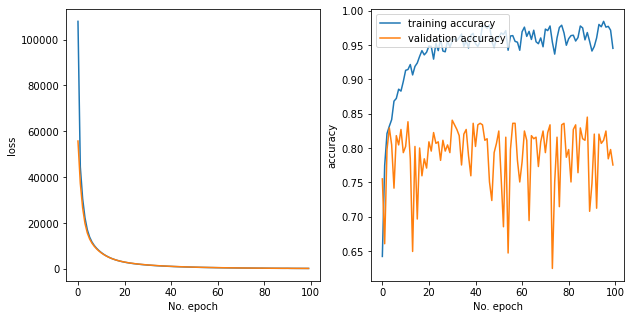

In [152]:
figure, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(history1.history['loss'], label='training loss')
ax[0].plot(history1.history['val_loss'], label='validation loss')

ax[1].plot(history1.history['accuracy'], label='training accuracy')
ax[1].plot(history1.history['val_accuracy'], label='validation accuracy')

ax[0].set_ylabel('loss')
ax[0].set_xlabel('No. epoch')
   
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('No. epoch')

plt.legend(loc="upper left")
plt.show()

In [439]:
model_test = model_2
model_test.layers

In [440]:
layer_outputs = [layer.output for layer in model_test.layers]

layer_outputs[2:]

[<KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'CONV1')>,
 <KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'BN1')>,
 <KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'activation_128')>,
 <KerasTensor: shape=(None, 30, 30, 16) dtype=float32 (created by layer 'max_pooling2d_160')>,
 <KerasTensor: shape=(None, 28, 28, 16) dtype=float32 (created by layer 'CONV2')>,
 <KerasTensor: shape=(None, 28, 28, 16) dtype=float32 (created by layer 'BN3')>,
 <KerasTensor: shape=(None, 28, 28, 16) dtype=float32 (created by layer 'activation_129')>,
 <KerasTensor: shape=(None, 13, 13, 16) dtype=float32 (created by layer 'average_pooling2d_76')>,
 <KerasTensor: shape=(None, 2704) dtype=float32 (created by layer 'flatten_76')>,
 <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'dense_layer')>,
 <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'dropout_9')>,
 <KerasTensor: shape=(None, 16) dtype=float32 (create

In [441]:
feature_map_model = tf.keras.models.Model(inputs = model_test.input, outputs = layer_outputs[2:])

feature_maps = feature_map_model.predict(img)

feature_maps[-1]

array([[0.10961744]], dtype=float32)

In [455]:
img = load_img('Test.png', target_size=(64, 64))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = feature_map_model.predict(img)

for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the input_30 is =======>> (1, 62, 62, 16)
The shape of the CONV1 is =======>> (1, 62, 62, 16)
The shape of the BN1 is =======>> (1, 62, 62, 16)
The shape of the activation_74 is =======>> (1, 30, 30, 16)
The shape of the max_pooling2d_71 is =======>> (1, 28, 28, 16)
The shape of the CONV2 is =======>> (1, 28, 28, 16)
The shape of the BN2 is =======>> (1, 28, 28, 16)
The shape of the activation_75 is =======>> (1, 13, 13, 16)
The shape of the max_pooling2d_72 is =======>> (1, 2704)
The shape of the CONV3 is =======>> (1, 16)
The shape of the BN3 is =======>> (1, 16)
The shape of the activation_76 is =======>> (1, 16)
The shape of the max_pooling2d_73 is =======>> (1, 16)
The shape of the average_pooling2d_27 is =======>> (1, 1)


<img src="Test.png" style="width:200px;height:200px;">

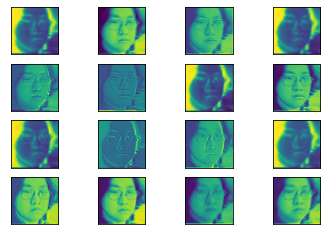

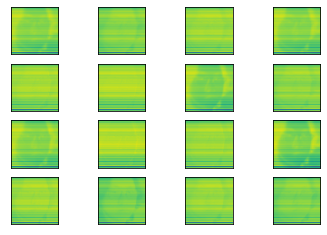

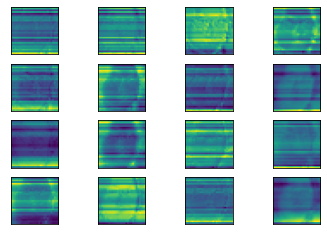

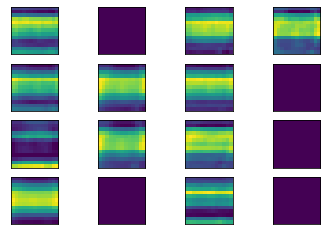

In [448]:
square = 4
for fmap in [feature_maps[i] for i in [0, 1, 4, 7]]:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
            
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1])
			ix += 1
	# show the figure
	plt.show()

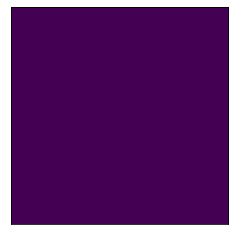

In [403]:
fmap = feature_maps[-1]
ax = plt.subplot()

ax.set_xticks([])
ax.set_yticks([])
plt.imshow(fmap)
plt.show()

## Experimental model 2

In [434]:
def model2(img_size = IMG_SIZE, data_augmentation = data_augmenter()):
    
    input_shape = img_size + (3,)
    
    # Input with appropriate input shape
    X_input = Input(shape = input_shape)

    # Apply data augmentation to the inputs
    X = data_augmentation(X_input)

    # First Block
    X = Conv2D(16, 3, strides = 1, name = 'CONV1')(X)
    X = BatchNormalization(axis = 1, epsilon=0.001, name = 'BN1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    
    # Second Block
    X = Conv2D(16, 3, strides = 1, name = 'CONV2',
                    kernel_regularizer=tf.keras.regularizers.L2(0.002),
                    activity_regularizer=tf.keras.regularizers.L2(0.002))(X)
    X = BatchNormalization(axis = 1, epsilon=0.0001, name = 'BN3')(X)
    X = Activation('relu')(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=2)(X)
    X = Flatten()(X)
    X = Dense(16, name='dense_layer',
                    kernel_regularizer=tf.keras.regularizers.L2(0.002),
                    activity_regularizer=tf.keras.regularizers.L2(0.002))(X)
    X = Dropout(rate = 0.2)(X)
    X = BatchNormalization(axis = 1, epsilon=0.001, name = 'BN4')(X)
    X = Activation('relu')(X)

    X = Dense(1, activation = 'sigmoid')(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='Model2')
    
    return model

### Training the model

In [437]:
model_2 = model2()
model_2.summary()
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history2 = model_2.fit(train_dataset, validation_data=validation_dataset, epochs=500)

Model: "Model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_68 (Sequential)   (None, 64, 64, 3)         0         
_________________________________________________________________
CONV1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 62, 62, 16)        248       
_________________________________________________________________
activation_128 (Activation)  (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 30, 30, 16)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 28, 28, 16)        2320 

Epoch 41/500
14/14 [==============================] - 6s 411ms/step - loss: 0.7122 - accuracy: 0.8194 - val_loss: 0.7560 - val_accuracy: 0.8247
Epoch 42/500
14/14 [==============================] - 6s 350ms/step - loss: 0.7053 - accuracy: 0.8261 - val_loss: 0.7547 - val_accuracy: 0.8202
Epoch 43/500
14/14 [==============================] - 6s 401ms/step - loss: 0.6822 - accuracy: 0.8351 - val_loss: 0.7433 - val_accuracy: 0.8180
Epoch 44/500
14/14 [==============================] - 6s 376ms/step - loss: 0.6781 - accuracy: 0.8396 - val_loss: 0.7450 - val_accuracy: 0.7933
Epoch 45/500
14/14 [==============================] - 6s 370ms/step - loss: 0.6717 - accuracy: 0.8407 - val_loss: 0.7929 - val_accuracy: 0.7483
Epoch 46/500
14/14 [==============================] - 5s 344ms/step - loss: 0.6730 - accuracy: 0.8374 - val_loss: 0.7201 - val_accuracy: 0.8090
Epoch 47/500
14/14 [==============================] - 6s 360ms/step - loss: 0.6641 - accuracy: 0.8357 - val_loss: 0.7380 - val_accuracy:

Epoch 98/500
14/14 [==============================] - 5s 315ms/step - loss: 0.4977 - accuracy: 0.8744 - val_loss: 0.6129 - val_accuracy: 0.8135
Epoch 99/500
14/14 [==============================] - 5s 327ms/step - loss: 0.5039 - accuracy: 0.8744 - val_loss: 0.6072 - val_accuracy: 0.8090
Epoch 100/500
14/14 [==============================] - 5s 333ms/step - loss: 0.4956 - accuracy: 0.8783 - val_loss: 0.5581 - val_accuracy: 0.8472
Epoch 101/500
14/14 [==============================] - 5s 332ms/step - loss: 0.4921 - accuracy: 0.8716 - val_loss: 0.5170 - val_accuracy: 0.8674
Epoch 102/500
14/14 [==============================] - 5s 333ms/step - loss: 0.4856 - accuracy: 0.8777 - val_loss: 0.5712 - val_accuracy: 0.8180
Epoch 103/500
14/14 [==============================] - 5s 318ms/step - loss: 0.4855 - accuracy: 0.8817 - val_loss: 0.5165 - val_accuracy: 0.8742
Epoch 104/500
14/14 [==============================] - 5s 312ms/step - loss: 0.4952 - accuracy: 0.8783 - val_loss: 0.5242 - val_accu

14/14 [==============================] - 5s 350ms/step - loss: 0.4045 - accuracy: 0.8979 - val_loss: 0.4704 - val_accuracy: 0.8652
Epoch 155/500
14/14 [==============================] - 5s 352ms/step - loss: 0.4190 - accuracy: 0.8923 - val_loss: 0.5119 - val_accuracy: 0.8449
Epoch 156/500
14/14 [==============================] - 5s 355ms/step - loss: 0.4127 - accuracy: 0.8974 - val_loss: 0.4673 - val_accuracy: 0.8742
Epoch 157/500
14/14 [==============================] - 6s 359ms/step - loss: 0.4019 - accuracy: 0.9013 - val_loss: 0.4472 - val_accuracy: 0.8876
Epoch 158/500
14/14 [==============================] - 6s 361ms/step - loss: 0.4036 - accuracy: 0.8951 - val_loss: 0.4802 - val_accuracy: 0.8607
Epoch 159/500
14/14 [==============================] - 5s 355ms/step - loss: 0.4074 - accuracy: 0.8878 - val_loss: 0.4531 - val_accuracy: 0.8787
Epoch 160/500
14/14 [==============================] - 5s 332ms/step - loss: 0.4013 - accuracy: 0.8951 - val_loss: 0.5035 - val_accuracy: 0.8292

14/14 [==============================] - 5s 360ms/step - loss: 0.3499 - accuracy: 0.9204 - val_loss: 0.4070 - val_accuracy: 0.8876
Epoch 211/500
14/14 [==============================] - 6s 413ms/step - loss: 0.3654 - accuracy: 0.9035 - val_loss: 0.4356 - val_accuracy: 0.8831
Epoch 212/500
14/14 [==============================] - 7s 435ms/step - loss: 0.3637 - accuracy: 0.9047 - val_loss: 0.4230 - val_accuracy: 0.8921
Epoch 213/500
14/14 [==============================] - 8s 485ms/step - loss: 0.3601 - accuracy: 0.9119 - val_loss: 0.4768 - val_accuracy: 0.8539
Epoch 214/500
14/14 [==============================] - 6s 410ms/step - loss: 0.3590 - accuracy: 0.9091 - val_loss: 0.4165 - val_accuracy: 0.8899
Epoch 215/500
14/14 [==============================] - 6s 358ms/step - loss: 0.3517 - accuracy: 0.9063 - val_loss: 0.4029 - val_accuracy: 0.8921
Epoch 216/500
14/14 [==============================] - 6s 354ms/step - loss: 0.3554 - accuracy: 0.9080 - val_loss: 0.3955 - val_accuracy: 0.8989

14/14 [==============================] - 7s 440ms/step - loss: 0.3164 - accuracy: 0.9254 - val_loss: 0.4077 - val_accuracy: 0.8854
Epoch 267/500
14/14 [==============================] - 6s 379ms/step - loss: 0.3212 - accuracy: 0.9215 - val_loss: 0.4671 - val_accuracy: 0.8742
Epoch 268/500
14/14 [==============================] - 6s 421ms/step - loss: 0.3334 - accuracy: 0.9108 - val_loss: 0.4061 - val_accuracy: 0.8899
Epoch 269/500
14/14 [==============================] - 6s 403ms/step - loss: 0.3357 - accuracy: 0.9192 - val_loss: 0.3915 - val_accuracy: 0.8944
Epoch 270/500
14/14 [==============================] - 6s 377ms/step - loss: 0.3133 - accuracy: 0.9254 - val_loss: 0.3986 - val_accuracy: 0.8966
Epoch 271/500
14/14 [==============================] - 6s 393ms/step - loss: 0.3096 - accuracy: 0.9271 - val_loss: 0.3867 - val_accuracy: 0.8944
Epoch 272/500
14/14 [==============================] - 6s 376ms/step - loss: 0.3190 - accuracy: 0.9215 - val_loss: 0.3901 - val_accuracy: 0.9079

14/14 [==============================] - 6s 364ms/step - loss: 0.2906 - accuracy: 0.9277 - val_loss: 0.3948 - val_accuracy: 0.8921
Epoch 323/500
14/14 [==============================] - 5s 343ms/step - loss: 0.2791 - accuracy: 0.9338 - val_loss: 0.5357 - val_accuracy: 0.8404
Epoch 324/500
14/14 [==============================] - 6s 407ms/step - loss: 0.2974 - accuracy: 0.9282 - val_loss: 0.3579 - val_accuracy: 0.9011
Epoch 325/500
14/14 [==============================] - 6s 388ms/step - loss: 0.2848 - accuracy: 0.9316 - val_loss: 0.3636 - val_accuracy: 0.9124
Epoch 326/500
14/14 [==============================] - 5s 344ms/step - loss: 0.2939 - accuracy: 0.9243 - val_loss: 0.4432 - val_accuracy: 0.8539
Epoch 327/500
14/14 [==============================] - 5s 318ms/step - loss: 0.2894 - accuracy: 0.9299 - val_loss: 0.3588 - val_accuracy: 0.9191
Epoch 328/500
14/14 [==============================] - 6s 371ms/step - loss: 0.2811 - accuracy: 0.9288 - val_loss: 0.3714 - val_accuracy: 0.9011

14/14 [==============================] - 5s 329ms/step - loss: 0.2681 - accuracy: 0.9372 - val_loss: 0.4158 - val_accuracy: 0.8674
Epoch 379/500
14/14 [==============================] - 5s 328ms/step - loss: 0.2757 - accuracy: 0.9265 - val_loss: 0.4038 - val_accuracy: 0.8719
Epoch 380/500
14/14 [==============================] - 5s 349ms/step - loss: 0.2558 - accuracy: 0.9490 - val_loss: 0.4031 - val_accuracy: 0.8989
Epoch 381/500
14/14 [==============================] - 5s 333ms/step - loss: 0.2747 - accuracy: 0.9383 - val_loss: 0.3639 - val_accuracy: 0.8966
Epoch 382/500
14/14 [==============================] - 5s 319ms/step - loss: 0.2643 - accuracy: 0.9434 - val_loss: 0.3720 - val_accuracy: 0.8921
Epoch 383/500
14/14 [==============================] - 5s 307ms/step - loss: 0.2562 - accuracy: 0.9462 - val_loss: 0.3542 - val_accuracy: 0.9101
Epoch 384/500
14/14 [==============================] - 5s 307ms/step - loss: 0.2577 - accuracy: 0.9383 - val_loss: 0.3762 - val_accuracy: 0.8854

14/14 [==============================] - 6s 388ms/step - loss: 0.2481 - accuracy: 0.9344 - val_loss: 0.4284 - val_accuracy: 0.8607
Epoch 435/500
14/14 [==============================] - 7s 426ms/step - loss: 0.2551 - accuracy: 0.9473 - val_loss: 0.4570 - val_accuracy: 0.8337
Epoch 436/500
14/14 [==============================] - 6s 350ms/step - loss: 0.2707 - accuracy: 0.9277 - val_loss: 0.4469 - val_accuracy: 0.8584
Epoch 437/500
14/14 [==============================] - 5s 342ms/step - loss: 0.2572 - accuracy: 0.9434 - val_loss: 0.4410 - val_accuracy: 0.8674
Epoch 438/500
14/14 [==============================] - 5s 336ms/step - loss: 0.2661 - accuracy: 0.9383 - val_loss: 0.3815 - val_accuracy: 0.8831
Epoch 439/500
14/14 [==============================] - 6s 370ms/step - loss: 0.2652 - accuracy: 0.9327 - val_loss: 0.3838 - val_accuracy: 0.8944
Epoch 440/500
14/14 [==============================] - 6s 367ms/step - loss: 0.2556 - accuracy: 0.9377 - val_loss: 0.3390 - val_accuracy: 0.9079

14/14 [==============================] - 6s 386ms/step - loss: 0.2536 - accuracy: 0.9316 - val_loss: 0.3398 - val_accuracy: 0.9034
Epoch 491/500
14/14 [==============================] - 6s 398ms/step - loss: 0.2391 - accuracy: 0.9495 - val_loss: 0.3220 - val_accuracy: 0.9101
Epoch 492/500
14/14 [==============================] - 6s 402ms/step - loss: 0.2412 - accuracy: 0.9422 - val_loss: 0.3260 - val_accuracy: 0.9124
Epoch 493/500
14/14 [==============================] - 6s 364ms/step - loss: 0.2412 - accuracy: 0.9394 - val_loss: 0.4082 - val_accuracy: 0.8809
Epoch 494/500
14/14 [==============================] - 5s 327ms/step - loss: 0.2537 - accuracy: 0.9355 - val_loss: 0.6591 - val_accuracy: 0.7573
Epoch 495/500
14/14 [==============================] - 5s 339ms/step - loss: 0.2392 - accuracy: 0.9372 - val_loss: 0.3710 - val_accuracy: 0.8809
Epoch 496/500
14/14 [==============================] - 5s 332ms/step - loss: 0.2482 - accuracy: 0.9366 - val_loss: 0.3482 - val_accuracy: 0.9079

### Plotting the learning curves

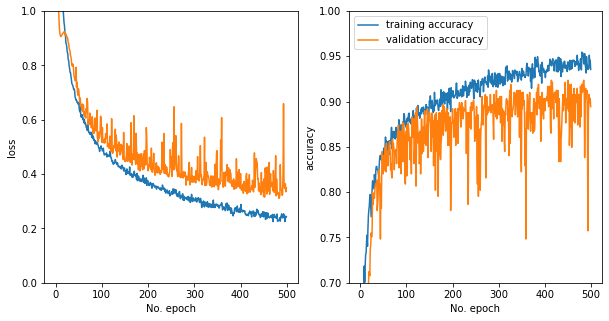

In [438]:
figure, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(history2.history['loss'], label='training loss')
ax[0].plot(history2.history['val_loss'], label='validation loss')

ax[1].plot(history2.history['accuracy'], label='training accuracy')
ax[1].plot(history2.history['val_accuracy'], label='validation accuracy')

ax[0].set_ylabel('loss')
ax[0].set_xlabel('No. epoch')
ax[0].set(ylim = (0, 1))
   
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('No. epoch')
ax[1].set(ylim = (0.7, 1))

plt.legend(loc="upper left")
plt.show()

In [456]:
model_2.save('models/model_v1')

INFO:tensorflow:Assets written to: models/model_v1/assets


## Experimental model 3

In [449]:
def model3(img_size = IMG_SIZE, data_augmentation = data_augmenter()):
    
    input_shape = img_size + (3,)
    
    # Input with appropriate input shape
    X_input = Input(shape = input_shape)

    # Apply data augmentation to the inputs
    X = data_augmentation(X_input)

    # Second Block
    X = Conv2D(16, 3, strides = 1, name = 'CONV1')(X)
    X = BatchNormalization(axis = 1, epsilon=0.0001, name = 'BN1')(X)
    X = Activation('relu', name = 'ACN1')(X)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=2)(X)
    
    # Second Block
    X = Conv2D(16, 3, strides = 1, name = 'CONV2',
                    kernel_regularizer=tf.keras.regularizers.L2(0.001),
                    activity_regularizer=tf.keras.regularizers.L2(0.001))(X)
    X = BatchNormalization(axis = 1, epsilon=0.0001, name = 'BN2')(X)
    X = Activation('relu', name = 'ACN2')(X)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=2)(X)
    
    # Third Block
    X = Conv2D(16, 3, strides = 1, name = 'CONV3',
                    kernel_regularizer=tf.keras.regularizers.L2(0.001),
                    activity_regularizer=tf.keras.regularizers.L2(0.001))(X)
    X = BatchNormalization(axis = 1, epsilon=0.0001, name = 'BN3')(X)
    X = Activation('relu', name = 'ACN3')(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=2)(X)
    X = Flatten()(X)
    X = Dense(16, name='dense_layer',
                    kernel_regularizer=tf.keras.regularizers.L2(0.001),
                    activity_regularizer=tf.keras.regularizers.L2(0.001))(X)
    X = Dropout(rate = 0.2)(X)
    X = BatchNormalization(axis = 1, epsilon=0.001, name = 'BN4')(X)
    X = Activation('relu', name = 'ACN4')(X)

    X = Dense(1, activation = 'sigmoid')(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='Model3')
    
    return model

In [395]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

### Training the model

In [453]:
model_3 = model3()
model_3.summary()
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history3 = model_3.fit(train_dataset, validation_data=validation_dataset, epochs=50)

Model: "Model3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_69 (Sequential)   (None, 64, 64, 3)         0         
_________________________________________________________________
CONV1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 62, 62, 16)        248       
_________________________________________________________________
ACN1 (Activation)            (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d_167 (MaxPoolin (None, 31, 31, 16)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 29, 29, 16)        2320 

14/14 [==============================] - 5s 350ms/step - loss: 0.5869 - accuracy: 0.7818 - val_loss: 1.1050 - val_accuracy: 0.4292
Epoch 38/50
14/14 [==============================] - 6s 369ms/step - loss: 0.6252 - accuracy: 0.7667 - val_loss: 1.3310 - val_accuracy: 0.4292
Epoch 39/50
14/14 [==============================] - 6s 384ms/step - loss: 0.6312 - accuracy: 0.7454 - val_loss: 0.7872 - val_accuracy: 0.5438
Epoch 40/50
14/14 [==============================] - 6s 376ms/step - loss: 0.6135 - accuracy: 0.7543 - val_loss: 1.0787 - val_accuracy: 0.4270
Epoch 41/50
14/14 [==============================] - 6s 381ms/step - loss: 0.6185 - accuracy: 0.7443 - val_loss: 0.8258 - val_accuracy: 0.4584
Epoch 42/50
14/14 [==============================] - 5s 352ms/step - loss: 0.5904 - accuracy: 0.7717 - val_loss: 0.7943 - val_accuracy: 0.5596
Epoch 43/50
14/14 [==============================] - 6s 373ms/step - loss: 0.6097 - accuracy: 0.7729 - val_loss: 0.9287 - val_accuracy: 0.5730
Epoch 44/50

### Plotting the learning curves

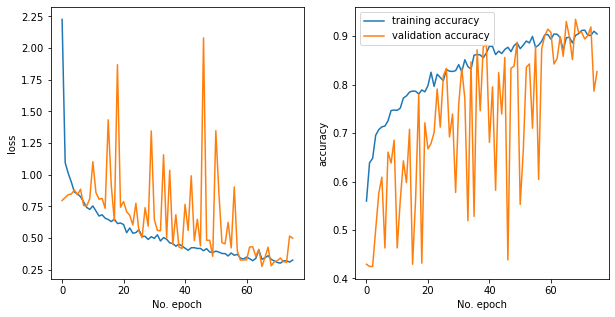

In [397]:
figure, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(history3.history['loss'], label='training loss')
ax[0].plot(history3.history['val_loss'], label='validation loss')

ax[1].plot(history3.history['accuracy'], label='training accuracy')
ax[1].plot(history3.history['val_accuracy'], label='validation accuracy')

ax[0].set_ylabel('loss')
ax[0].set_xlabel('No. epoch')
   
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('No. epoch')

plt.legend(loc="upper left")
plt.show()

## Experimental model 4

In [330]:
def model4(img_size = IMG_SIZE, data_augmentation = data_augmenter()):
    
    input_shape = img_size + (3,)
    
    # Input with appropriate input shape
    X_input = Input(shape = input_shape)

    # Apply data augmentation to the inputs
    X = data_augmentation(X_input)

    # Second Block
    X = Conv2D(8, 3, strides = 1, name = 'CONV1',
                    kernel_regularizer=tf.keras.regularizers.L2(0.01),
                    activity_regularizer=tf.keras.regularizers.L2(0.01), 
                    activation = 'relu')(X)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=2)(X)
    
    # Second Block
    X = Conv2D(8, 3, strides = 1, name = 'CONV2',
                    kernel_regularizer=tf.keras.regularizers.L2(0.01),
                    activity_regularizer=tf.keras.regularizers.L2(0.01), 
                    activation = 'relu')(X)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=2)(X)
    
    # Second Block
    X = Conv2D(16, 3, strides = 1, name = 'CONV3',
                    kernel_regularizer=tf.keras.regularizers.L2(0.01),
                    activity_regularizer=tf.keras.regularizers.L2(0.01), 
                    activation = 'relu')(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=2)(X)
    X = Flatten()(X)
    X = Dense(16, name='dense_layer',
                    kernel_regularizer=tf.keras.regularizers.L2(0.01),
                    activity_regularizer=tf.keras.regularizers.L2(0.01))(X)
    X = BatchNormalization(axis = 1, epsilon=0.001, name = 'BN4')(X)

    X = Dense(1, activation = 'sigmoid')(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='Model4')
    
    return model

In [331]:
model_4 = model4()
model_4.summary()
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history4 = model_4.fit(train_dataset, validation_data=validation_dataset, epochs=50)

Model: "Model4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_57 (Sequential)   (None, 64, 64, 3)         0         
_________________________________________________________________
CONV1 (Conv2D)               (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 31, 31, 8)         0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 29, 29, 8)         584       
_________________________________________________________________
CONV3 (Conv2D)               (None, 27, 27, 16)        1168      
_________________________________________________________________
average_pooling2d_60 (Averag (None, 13, 13, 16)        0    

Epoch 46/50
14/14 [==============================] - 3s 202ms/step - loss: 0.6397 - accuracy: 0.7027 - val_loss: 0.7381 - val_accuracy: 0.5820
Epoch 47/50
14/14 [==============================] - 3s 197ms/step - loss: 0.6281 - accuracy: 0.7112 - val_loss: 0.9615 - val_accuracy: 0.5596
Epoch 48/50
14/14 [==============================] - 3s 177ms/step - loss: 0.6356 - accuracy: 0.7106 - val_loss: 0.6913 - val_accuracy: 0.6899
Epoch 49/50
14/14 [==============================] - 3s 173ms/step - loss: 0.6338 - accuracy: 0.7022 - val_loss: 0.7442 - val_accuracy: 0.5865
Epoch 50/50
14/14 [==============================] - 3s 174ms/step - loss: 0.6343 - accuracy: 0.7084 - val_loss: 0.7410 - val_accuracy: 0.6022


### Plotting the learning curves

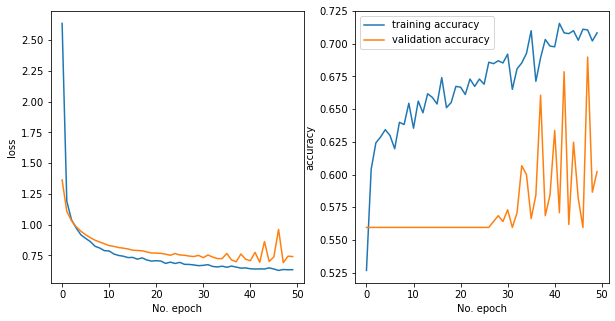

In [332]:
figure, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(history4.history['loss'], label='training loss')
ax[0].plot(history4.history['val_loss'], label='validation loss')

ax[1].plot(history4.history['accuracy'], label='training accuracy')
ax[1].plot(history4.history['val_accuracy'], label='validation accuracy')

ax[0].set_ylabel('loss')
ax[0].set_xlabel('No. epoch')
   
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('No. epoch')

plt.legend(loc="upper left")
plt.show()